In [1]:
import os
import tensorflow as tf
import dask
import dask.array as da
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [17]:
train_x = da.from_npy_stack('/home/skyolia/JupyterProjects/segmentation/TGS Salt/dataset/train_x')
train_y = da.from_npy_stack('/home/skyolia/JupyterProjects/segmentation/TGS Salt/dataset/train_y')
test_x = da.from_npy_stack('/home/skyolia/JupyterProjects/segmentation/TGS Salt/dataset/test_x')
test_y = da.from_npy_stack('/home/skyolia/JupyterProjects/segmentation/TGS Salt/dataset/test_y')
train_x, train_y, test_x, test_y

(dask.array<from-npy-stack, shape=(2400, 128, 128, 1), dtype=float32, chunksize=(2400, 128, 128, 1)>,
 dask.array<from-npy-stack, shape=(2400, 128, 128, 1), dtype=float32, chunksize=(2400, 128, 128, 1)>,
 dask.array<from-npy-stack, shape=(1600, 128, 128, 1), dtype=float32, chunksize=(1600, 128, 128, 1)>,
 dask.array<from-npy-stack, shape=(1600, 128, 128, 1), dtype=float32, chunksize=(1600, 128, 128, 1)>)

In [22]:
x = np.random.uniform(-2, 2, size=(10))
print(x)
np.where(((x>-1) & (x<1)))

[-0.94395536  0.4815205  -0.29242972 -1.23810915 -0.95808626 -1.64664315
  0.92577301  0.98480456  0.63183017 -0.28285236]


(array([0, 1, 2, 4, 6, 7, 8, 9]),)

In [28]:
s = train_y[1].compute().flatten()
z = np.sum(s==0)
o = np.sum(s==1)
z+o, s.size, s.shape, z

(15935, 16384, (16384,), 7647)

In [30]:
s[69]

0.30400085

In [3]:
class LRTensorBoard(tf.keras.callbacks.TensorBoard):
    '''
    Add learning rate evolution to Tensorboard
    '''
    def __init__(self, log_dir):
        super().__init__(log_dir=log_dir)

    def on_epoch_end(self, epoch, logs=None):
        logs['lr'] = tf.keras.backend.eval(self.model.optimizer.lr)
        super().on_epoch_end(epoch, logs)
        
def build_block(input_layer, filters, norm=True, k=(3, 3)):
    layer = tf.keras.layers.Conv2D(filters, kernel_size=k, padding='same', use_bias=not norm, kernel_initializer='glorot_normal')(input_layer)
    if norm:
        layer = tf.keras.layers.BatchNormalization()(layer)
    layer = tf.keras.layers.Activation('elu')(layer)
    return layer

def build_unet(n_filters=16, dropout=0.5):
    image_input = tf.keras.Input(shape=(128, 128, 1), name='input_layer')
    
    conv_1 = build_block(image_input, n_filters)
    conv_2 = build_block(conv_1, n_filters)
    pool_1 = tf.keras.layers.MaxPooling2D(padding='same')(conv_2)
    drop_1 = tf.keras.layers.Dropout(dropout)(pool_1)
    
    conv_3 = build_block(drop_1, n_filters * 2)
    conv_4 = build_block(conv_3, n_filters * 2)
    pool_2 = tf.keras.layers.MaxPooling2D(padding='same')(conv_4)
    drop_2 = tf.keras.layers.Dropout(dropout)(pool_2)
    
    conv_5 = build_block(drop_2, n_filters * 4)
    conv_6 = build_block(conv_5, n_filters * 4)
    pool_3 = tf.keras.layers.MaxPooling2D(padding='same')(conv_6)
    drop_3 = tf.keras.layers.Dropout(dropout)(pool_3)
    
    conv_7 = build_block(drop_3, n_filters * 8)
    conv_8 = build_block(conv_7, n_filters * 8)
    pool_4 = tf.keras.layers.MaxPooling2D(padding='same')(conv_8)
    drop_4 = tf.keras.layers.Dropout(dropout)(pool_4)
    
    conv_9 = build_block(drop_4, n_filters * 16)
    conv_10 = build_block(conv_9, n_filters * 16)
    
    donv_1 = tf.keras.layers.Convolution2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(conv_10)
    donv_1 = tf.keras.layers.concatenate([donv_1, conv_8])
    donv_1 = tf.keras.layers.Dropout(dropout)(donv_1)
    conv_11 = build_block(donv_1, n_filters * 8)
    conv_12 = build_block(conv_11, n_filters * 8)
    
    donv_2 = tf.keras.layers.Convolution2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(conv_12)
    donv_2 = tf.keras.layers.concatenate([donv_2, conv_6])
    donv_2 = tf.keras.layers.Dropout(dropout)(donv_2)
    conv_13 = build_block(donv_2, n_filters * 4)
    conv_14 = build_block(conv_13, n_filters * 4)
    
    donv_3 = tf.keras.layers.Convolution2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(conv_14)
    donv_3 = tf.keras.layers.concatenate([donv_3, conv_4])
    donv_3 = tf.keras.layers.Dropout(dropout)(donv_3)
    conv_15 = build_block(donv_3, n_filters * 2)
    conv_16 = build_block(conv_15, n_filters * 2)
    
    donv_4 = tf.keras.layers.Convolution2DTranspose(n_filters, (3, 3), strides = (2, 2), padding = 'same')(conv_16)
    donv_4 = tf.keras.layers.concatenate([donv_4, conv_2])
    donv_4 = tf.keras.layers.Dropout(dropout)(donv_4)
    conv_17 = build_block(donv_4, n_filters)
    conv_18 = build_block(conv_17, n_filters)
    
    output = tf.keras.layers.Conv2D(1, (1, 1), kernel_initializer='glorot_normal', activation='sigmoid')(conv_18)
    model = tf.keras.Model(inputs=image_input, outputs=output)
    return model

In [4]:
model = build_unet()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 144         input_layer[0][0]                
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 16) 0           batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d_1 (

In [5]:
epochs, batch_size, lr, filepath = 10000, 16, 0.001, "day_1.weights.best.hdf5"
steps_per_epoch = int(np.ceil(train_y.shape[0]/batch_size))

data_gen_args = dict(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True, vertical_flip=True)
image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)
mask_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1
image_datagen.fit(train_x, augment=True, seed=seed)
mask_datagen.fit(train_y, augment=True, seed=seed)

image_generator = image_datagen.flow(x=train_x, batch_size=batch_size, seed=seed)
mask_generator = mask_datagen.flow(x=train_y, batch_size=batch_size, seed=seed)
train_generator = zip(image_generator, mask_generator)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator().flow(x=test_x, y=test_y, batch_size=batch_size)
tblr = LRTensorBoard(log_dir=os.getcwd())
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

opt = tf.keras.optimizers.Adam() # 
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

model.fit_generator(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    verbose=1,
                    validation_data=test_generator,
                    validation_steps=int(np.ceil(test_y.shape[0]/batch_size)),
                    use_multiprocessing=False,
                    workers=12,
                    shuffle=True,
                    #initial_epoch=65,
                    callbacks=[checkpoint, tblr])

Epoch 1/10000
149/150 [============================>.] - ETA: 0s - loss: 8.5004 - acc: 0.7410
Epoch 00001: val_acc improved from -inf to 0.23358, saving model to day_1.weights.best.hdf5
150/150 [==============================] - 60s 398ms/step - loss: 8.4762 - acc: 0.7420 - val_loss: 189.8586 - val_acc: 0.2336
Epoch 2/10000
149/150 [============================>.] - ETA: 0s - loss: 6.2127 - acc: 0.8288
Epoch 00002: val_acc improved from 0.23358 to 0.45492, saving model to day_1.weights.best.hdf5
150/150 [==============================] - 28s 185ms/step - loss: 6.2185 - acc: 0.8286 - val_loss: 17.0466 - val_acc: 0.4549
Epoch 3/10000
149/150 [============================>.] - ETA: 0s - loss: 5.8875 - acc: 0.8323
Epoch 00003: val_acc improved from 0.45492 to 0.51962, saving model to day_1.weights.best.hdf5
150/150 [==============================] - 28s 186ms/step - loss: 5.8818 - acc: 0.8324 - val_loss: 45.8906 - val_acc: 0.5196
Epoch 4/10000
149/150 [============================>.] - ETA

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/skyolia/anaconda3/envs/tensorflow_gpuenv/lib/python3.6/site-packages/tensorflow/python/keras/engine/training_generator.py", line 171, in fit_generator
    x, y, sample_weight=sample_weight, class_weight=class_weight)
  File "/home/skyolia/anaconda3/envs/tensorflow_gpuenv/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py", line 1828, in train_on_batch
    outputs = self.train_function(ins)
  File "/home/skyolia/anaconda3/envs/tensorflow_gpuenv/lib/python3.6/site-packages/tensorflow/python/keras/backend.py", line 2978, in __call__
    run_metadata=self.run_metadata)
  File "/home/skyolia/anaconda3/envs/tensorflow_gpuenv/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1399, in __call__
    run_metadata_ptr)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/skyolia/anaconda3/envs/tensorflow_gpuenv/lib/python3.6/s

KeyboardInterrupt: 

In [7]:
model.load_weights("day_1.weights.best.hdf5")
opt = tf.keras.optimizers.Adam()
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
scores = model.evaluate(test_x, test_y)
scores

1600/1600 [==============================] - 4s 2ms/step


[4.190644578933716, 0.9480862045288085]

In [9]:
batch_size=16
prediction = model.predict(test_x, batch_size=batch_size, verbose=1)
prediction.shape

1600/1600 [==============================] - 5s 3ms/step


(1600, 128, 128, 1)

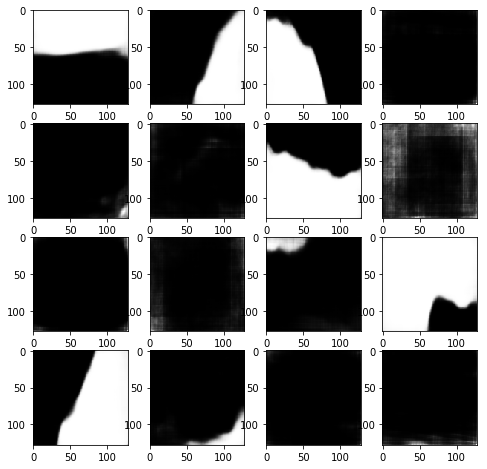

In [31]:
rnd_ind = np.random.choice(1600, 16, False)
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 4
for x, i in enumerate(rnd_ind):
    fig.add_subplot(rows, columns, x+1)
    plt.imshow(np.squeeze(prediction[i]), cmap=plt.get_cmap('gray'))
plt.show()

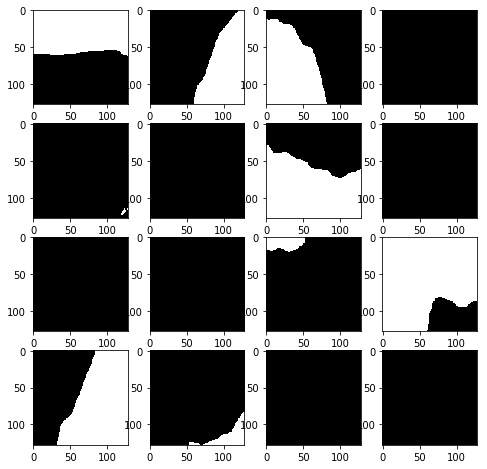

In [32]:
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 4
for x, i in enumerate(rnd_ind):
    fig.add_subplot(rows, columns, x+1)
    plt.imshow(np.squeeze((prediction[i] > 0.5).astype(np.uint8)), cmap=plt.get_cmap('gray'))
plt.show()

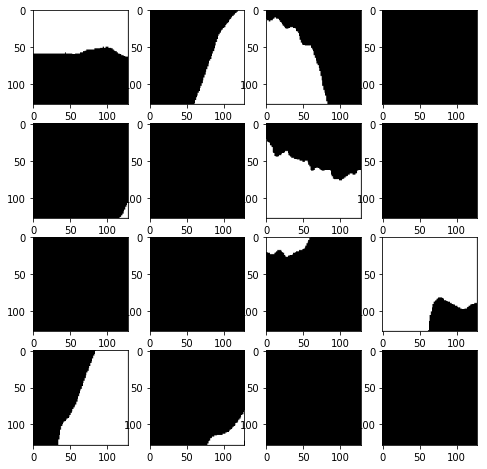

In [33]:
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 4
for x, i in enumerate(rnd_ind):
    fig.add_subplot(rows, columns, x+1)
    plt.imshow(np.squeeze(test_y[i]), cmap=plt.get_cmap('gray'))
plt.show()

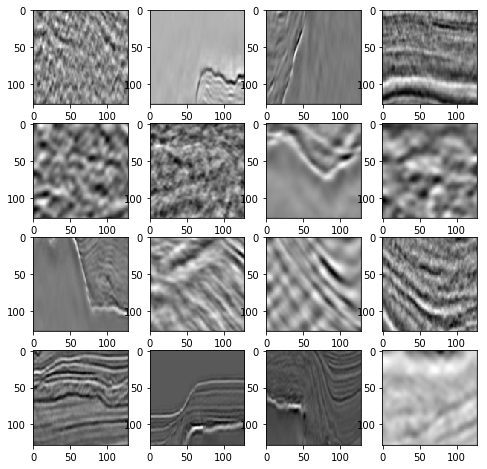

In [30]:
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 4
for x, i in enumerate(rnd_ind):
    fig.add_subplot(rows, columns, x+1)
    plt.imshow(np.squeeze(test_x[i]), cmap=plt.get_cmap('gray'))
plt.show()